# **Fitting of Experimental Translational Forces in MRI Fields**

## **1. Introduction**
This notebook analyzes experimental data to determine whether it fits a linear model as predicted by theory. The goal is to understand how unhomgenious magnetic fields influence translational forces on a metalic cylinder. 

The theoretical expectation is that the slope of the fit should be proportional to the susceptibility of the affected material and inversely proportional to its density. 

### **Experimental Setup**
- An **electromagnet** (copper solenoid) is powered with **DC current** in the lab.
- A **pendulum** (small metallic cylinder) hangs from a **mast** positioned **8 cm** from the coil.
- The pendulum's displacement is measured using a **ruler attached to the mast**.
- A **Gaussmeter** is mounted on a **servo-controlled rail**, for measurments of the magnetic field at three points around equilibrium whenever the pendulum reaches a new position.
- Measurements of position are taken only in the **first centimeter** toward the coil.


## **2. Data Preprocessing**

This nb drawns upon RawMeasuments.csv, this files contains measurements from the lab as well as quick notes and some quick calculations.

### **CSV Structure and Cleaning**
- The **second row** contains only units, symbols, and personal notes $\rightarrow$ **dropped** to maintain consistency in headers.
- The **first column** (`N`) was removed since **Pandas automatically indexes the DataFrame**.
- Precomputed **Excel statistics were removed** to allow Pandas to handle all calculations.
- Column **"L is in mm"** was renamed to `tan_theta`.
  - This was a little note to myself
  - Then we ultimately need:
  - **tan($\theta$) = asin(position/L)**
  - `L` is a constant (955 mm).
- Column **"955"** was relabeled as `B0_dBdx` for its role in later calculations.

### **Handling Missing Data**
- The **first row** of recorded data contains **NaN values** since there is no difference in `B1` and `B2` when the coil is off.
- Instead of dropping it, we **exclude it from plotting** but keep it for analysis.
- Standard deviation for `B1` might change if NaNs are ignored, but it is unlikely to have a large effect.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "RawMeasurments.csv" 
df = pd.read_csv(file_path)
#df

In [3]:
# Drop the first row (header row inside the data) and reset index
df_clean = df.iloc[1:].reset_index(drop=True)
df_clean = df.iloc[1:].reset_index(drop=True).drop(columns=["N"], errors='ignore')
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')

# Fix mislabeled columns
df_clean.rename(columns={"L is in mm": "tan_theta", "955": "B0_dBdx"}, inplace=True)
#df_clean

In [4]:
# Drop the excel calculatoins
columns_to_drop = ["MF-0.5mm Avg", "MagField  Avg", "MF+0.5mm Avg", "Gradient", 
                   "Angular position", "tan_theta", "B0_dBdx"]

df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')
#df_clean

In [5]:
# Identify columns for Magnetic Field Intensity at different positions
mf_minus_cols = [col for col in df.columns if "Magnetic Field Intensity at PositionNm0.5mm" in col]
mf_center_cols = [col for col in df.columns if "Magnetic Field Intensity at PositionN" in col and "-0.5mm" not in col and "+0.5mm" not in col]
mf_plus_cols = [col for col in df.columns if "Magnetic Field Intensity at PositionNp0.5mm" in col]

# Calculate averages, standard deviations and standard error mean 
df_clean["MF-0.5mm Avg"] = df_clean[mf_minus_cols].mean(axis=1)
df_clean["MF-0.5mm Std"] = df_clean[mf_minus_cols].std(axis=1)
df_clean["MF-0.5mm SEM"] = df_clean[mf_minus_cols].sem(axis=1)

df_clean["MagField Avg"] = df_clean[mf_center_cols].mean(axis=1)
df_clean["MagField Std"] = df_clean[mf_center_cols].std(axis=1)
df_clean["MagField SEM"] = df_clean[mf_center_cols].sem(axis=1)

df_clean["MF+0.5mm Avg"] = df_clean[mf_plus_cols].mean(axis=1)
df_clean["MF+0.5mm Std"] = df_clean[mf_plus_cols].std(axis=1)
df_clean["MF+0.5mm SEM"] = df_clean[mf_plus_cols].sem(axis=1)


df_clean.to_csv('cleanData.csv', index=False)
#df_clean

## **3. Data Processing & Model Fitting**

### **3.1 Calculating Key Variables**
- After removing Excel-calculated values, we compute:
  - **tan($ \theta $)** and its **uncertainty**.
  - **Magnetic field gradient (dB/dx)**.
  - **B0 * dB/dx**, for plotting.

### **3.2 Uncertainty Analysis**
#### **tan($\theta$) and error propagation**: 
  - Derived using **partial derivatives**.
  - Initial **systematic uncertainty of 0.5** assumed.

#### **Calculation of $ \theta $ and $ tan(\theta) $**

$$
\theta = arctan \left( \frac{x}{L} \right)
$$

$$
tan(\theta) = tan \left( arctan \left( \frac{x}{L} \right) \right)
$$

#### **Uncertainty Propagation for $ tan(arctan(x/L)) $**


#### **Total Uncertainty Propagation**
Applying the chain rule:

$$
\frac{d(tan\theta)}{dx} = \frac{1}{cos^2(\theta)} \cdot \frac{d\theta}{dx} \cdot dx
$$

$$
\frac{d(tan\theta)}{dL} = \frac{1}{cos^2(\theta)} \cdot \frac{d\theta}{dL} \cdot dL
$$

$$
d(tan\theta) = \sqrt{\left( \frac{d(tan\theta)}{dx} \right)^2 + \left( \frac{d(tan\theta)}{dL} \right)^2}
$$


In [6]:
L = 955 #mm
# theta and tan(theta)
df_clean["theta"] = np.arctan(df_clean["Position"] / L)

# Uncertainty

# Function for uncertainty propagation in tan(arcsin(x/L))
def uncertainty_tan_arcsin(x, dx, L, dL):
    theta = np.arctan(x / L)
    tan_theta = np.tan(theta)

    # Partial derivatives
    dtheta_dx = 1 / (L * np.sqrt(1 - (x / L) ** 2))
    dtheta_dL = -x / (L**2 * np.sqrt(1 - (x / L) ** 2))
    
    dtan_theta_dtheta = 1 / np.cos(theta)**2

    # Total uncertainty propagation
    dtan_theta_dx = dtan_theta_dtheta * dtheta_dx * dx
    dtan_theta_dL = dtan_theta_dtheta * dtheta_dL * dL

    dtan_theta = np.sqrt(dtan_theta_dx**2 + dtan_theta_dL**2)
    
    return tan_theta, dtan_theta

dx = dL = 0.5 #mm
df_clean["tan_theta"], df_clean["tan_theta Std"] = uncertainty_tan_arcsin(df_clean["Position"],dx,L,dL)

print(df_clean.iloc[:, -2:])

    tan_theta  tan_theta Std
0    0.000000       0.000524
1    0.001047       0.000524
2    0.002094       0.000524
3    0.003141       0.000524
4    0.004188       0.000524
5    0.005236       0.000524
6    0.006283       0.000524
7    0.007330       0.000524
8    0.008377       0.000524
9    0.009424       0.000524
10   0.010471       0.000524
11   0.011518       0.000524


#### **B0 * dB/dx and error propagation**:
  - Initially tried **error propagation via squared law**.
      - Found errors too small to be useful.
  - Switched to **fractional uncertainty** propagation, which improved **Chi-squared statistics**.
      - **Error increases with B**, noticeable in final multiplication of B0 * dB/dx.
  - As the error increases and Chi-squared is not as reliable, we tried error on the mean.

#### **Central Difference Approximation for $ \frac{dB}{dx} $**

The central difference formula used to approximate the derivative is:

$$
\frac{dB}{dx} = \frac{| B(x+0.5) - B(x-0.5) |}{dx} = \frac{| B_{+0.5} - B_{-0.5} |}{dx}
$$

where $ dx = 1 $ mm.

##### **Error Propagation for $ \frac{dB}{dx} $**

Using standard error propagation rules:

$$
\sigma_{dBdx} = \frac{\sqrt{\sigma_{B_{+0.5}}^2 + \sigma_{B_{-0.5}}^2}}{dx}
$$

$$
SEM_{dBdx} = \frac{\sqrt{SEM_{B_{+0.5}}^2 + SEM_{B_{-0.5}}^2}}{dx}
$$

#### **Multiplication of $ B_0 $ and $ \frac{dB}{dx} $**

#### **Uncertainty Propagation for $ B_0 \cdot \frac{dB}{dx} $**

##### **Fractional Uncertainties**
$$
\text{Fractional Std} = \sqrt{\left( \frac{\sigma_{B_0}}{B_0} \right)^2 + \left( \frac{\sigma_{dBdx}}{dBdx} \right)^2} \times (B_0 \cdot dBdx)
$$

$$
\text{Fractional SEM} = \sqrt{\left( \frac{SEM_{B_0}}{B_0} \right)^2 + \left( \frac{SEM_{dBdx}}{dBdx} \right)^2} \times (B_0 \cdot dBdx)
$$

##### **Absolute Uncertainties**
$$
\sigma_{B_0 \cdot dBdx} = \sqrt{\sigma_{B_0}^2 + \sigma_{dBdx}^2}
$$

$$
SEM_{B_0 \cdot dBdx} = \sqrt{SEM_{B_0}^2 + SEM_{dBdx}^2}
$$

In [7]:
# central difference db/dx
dx = 1 #mm
df_clean["dBdx"] = np.abs(df_clean["MF+0.5mm Avg"] - df_clean["MF-0.5mm Avg"] / dx  )

# error propagation of db/dx
df_clean["dBdx Std"] = np.sqrt((df_clean["MF+0.5mm Std"]**2 + df_clean["MF-0.5mm Std"]**2)) / dx
df_clean["dBdx SEM"] = np.sqrt((df_clean["MF+0.5mm SEM"]**2 + df_clean["MF-0.5mm SEM"]**2)) / dx

# B0 * dB/dx
df_clean["B0 * dBdx"] = df_clean["MagField Avg"] * df_clean["dBdx"]

# uncertainty for B0 * dB/dx

# fractional
df_clean["B0 * dBdx Fractional Std"] = np.sqrt((df_clean["MagField Std"]/df_clean["MagField Avg"])**2 + 
         (df_clean["dBdx Std"]/df_clean["dBdx"])**2) * df_clean["B0 * dBdx"]
df_clean["B0 * dBdx Fractional SEM"] = np.sqrt((df_clean["MagField SEM"]/df_clean["MagField Avg"])**2 + 
         (df_clean["dBdx SEM"]/df_clean["dBdx"])**2) * df_clean["B0 * dBdx"]

# uncertainty for B0 * dB/dx
df_clean["B0 * dBdx Std"] = np.sqrt((df_clean["MagField Std"])**2 + 
        (df_clean["dBdx Std"])**2)
df_clean["B0 * dBdx SEM"] = np.sqrt((df_clean["MagField SEM"])**2 + 
        (df_clean["dBdx SEM"])**2)

df_clean.to_csv('cleanDatawstdsem.csv', index=False)

print(df_clean.iloc[:, -8:])

        dBdx  dBdx Std  dBdx SEM  B0 * dBdx  B0 * dBdx Fractional Std  \
0        NaN       NaN       NaN        NaN                       NaN   
1   0.011111  0.124722  0.041574   0.031523                  0.353842   
2   0.144444  0.123603  0.041201   0.814239                  0.696896   
3   0.211111  0.113039  0.037680   1.512963                  0.810514   
4   0.122222  0.131233  0.043744   1.149342                  1.234148   
5   0.288889  0.142400  0.047467   3.006584                  1.482663   
6   0.188889  0.126930  0.042310   2.207901                  1.483835   
7   0.177778  0.110554  0.036851   2.249877                  1.399266   
8   0.344444  0.139443  0.046481   4.846461                  1.962945   
9   0.366667  0.114261  0.038087   5.756667                  1.794991   
10  0.300000  0.110554  0.036851   5.160000                  1.902132   
11  0.288889  0.130171  0.043390   5.250288                  2.366122   

    B0 * dBdx Fractional SEM  B0 * dBdx Std  B0 * 

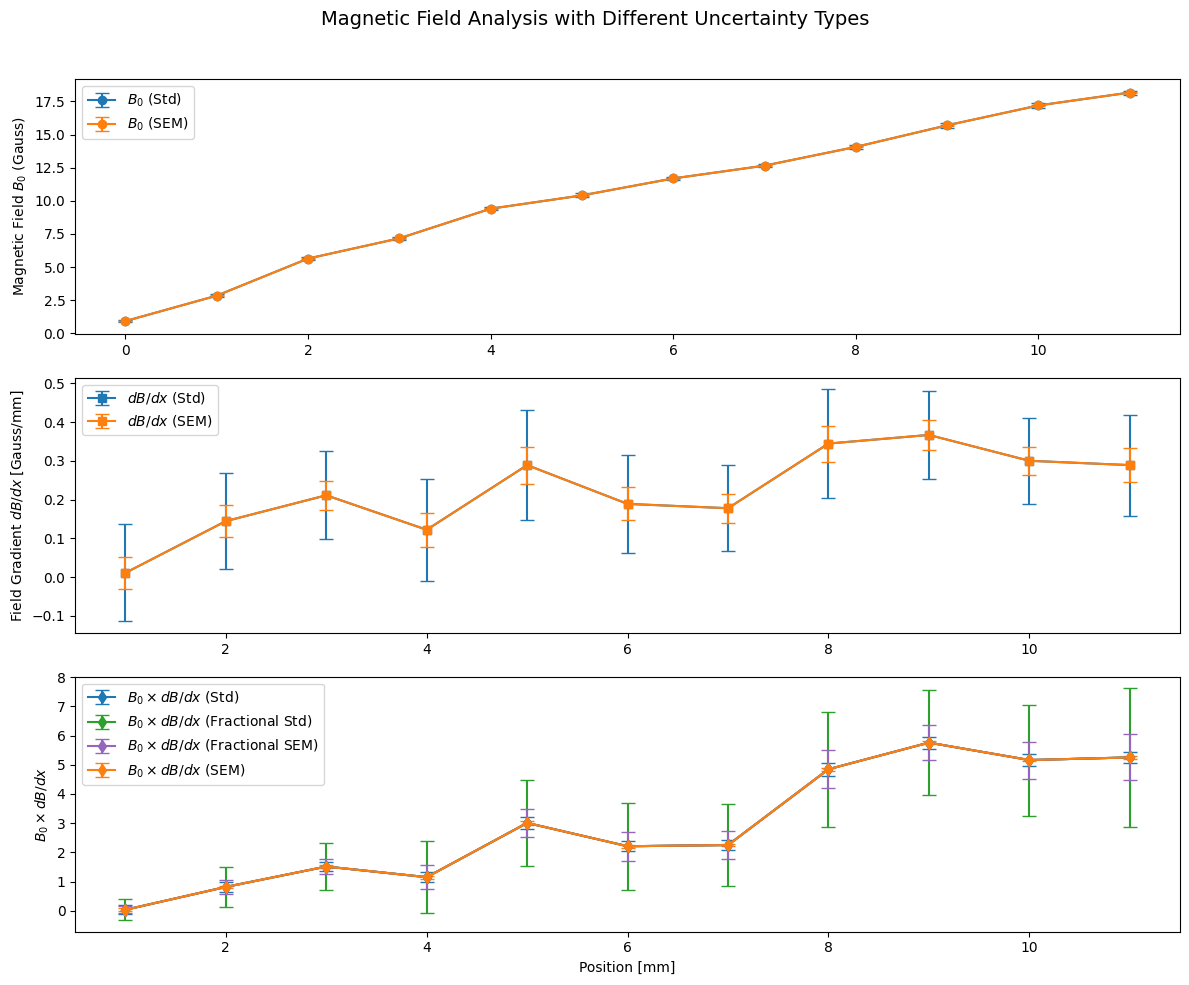

In [8]:
# Create a single figure with different error bar colors for Std, SEM, and Fractional uncertainties
plt.figure(figsize=(12, 10))
plt.suptitle("Magnetic Field Analysis with Different Uncertainty Types", fontsize=14)

# Define colors for different uncertainties
std_color = 'tab:blue'
sem_color = 'tab:orange'
frac_color = 'tab:purple'
frac_color1 = 'tab:green'

# Plot B0 with different error bars
plt.subplot(3, 1, 1)
plt.errorbar(df_clean["Position"], df_clean["MagField Avg"], yerr=df_clean["MagField Std"], fmt='o-', capsize=5, color=std_color, label='$B_0$ (Std)')
plt.errorbar(df_clean["Position"], df_clean["MagField Avg"], yerr=df_clean["MagField SEM"], fmt='o-', capsize=5, color=sem_color, label='$B_0$ (SEM)')
plt.ylabel('Magnetic Field $B_0$ (Gauss)')
plt.legend()

# Plot dB/dx with different error bars
plt.subplot(3, 1, 2)
plt.errorbar(df_clean["Position"], df_clean["dBdx"], yerr=df_clean["dBdx Std"], fmt='s-', capsize=5, color=std_color, label='$dB/dx$ (Std)')
plt.errorbar(df_clean["Position"], df_clean["dBdx"], yerr=df_clean["dBdx SEM"], fmt='s-', capsize=5, color=sem_color, label='$dB/dx$ (SEM)')
plt.ylabel('Field Gradient $dB/dx$ [Gauss/mm]')
plt.legend()

# Plot B0 * dB/dx with different error bars
plt.subplot(3, 1, 3)
plt.errorbar(df_clean["Position"], df_clean["B0 * dBdx"], yerr=df_clean["B0 * dBdx Std"], fmt='d-', capsize=5, color=std_color, label='$B_0 \\times dB/dx$ (Std)')
plt.errorbar(df_clean["Position"], df_clean["B0 * dBdx"], yerr=df_clean["B0 * dBdx Fractional Std"], fmt='d-', capsize=5, color=frac_color1, label='$B_0 \\times dB/dx$ (Fractional Std)')
plt.errorbar(df_clean["Position"], df_clean["B0 * dBdx"], yerr=df_clean["B0 * dBdx Fractional SEM"], fmt='d-', capsize=5, color=frac_color, label='$B_0 \\times dB/dx$ (Fractional SEM)')
plt.errorbar(df_clean["Position"], df_clean["B0 * dBdx"], yerr=df_clean["B0 * dBdx SEM"], fmt='d-', capsize=5, color=sem_color, label='$B_0 \\times dB/dx$ (SEM)')
plt.xlabel('Position [mm]')
plt.ylabel('$B_0 \\times dB/dx$')
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Assests/Uncertainty_Propagation_Plot.png", dpi=300, bbox_inches='tight')
plt.show()


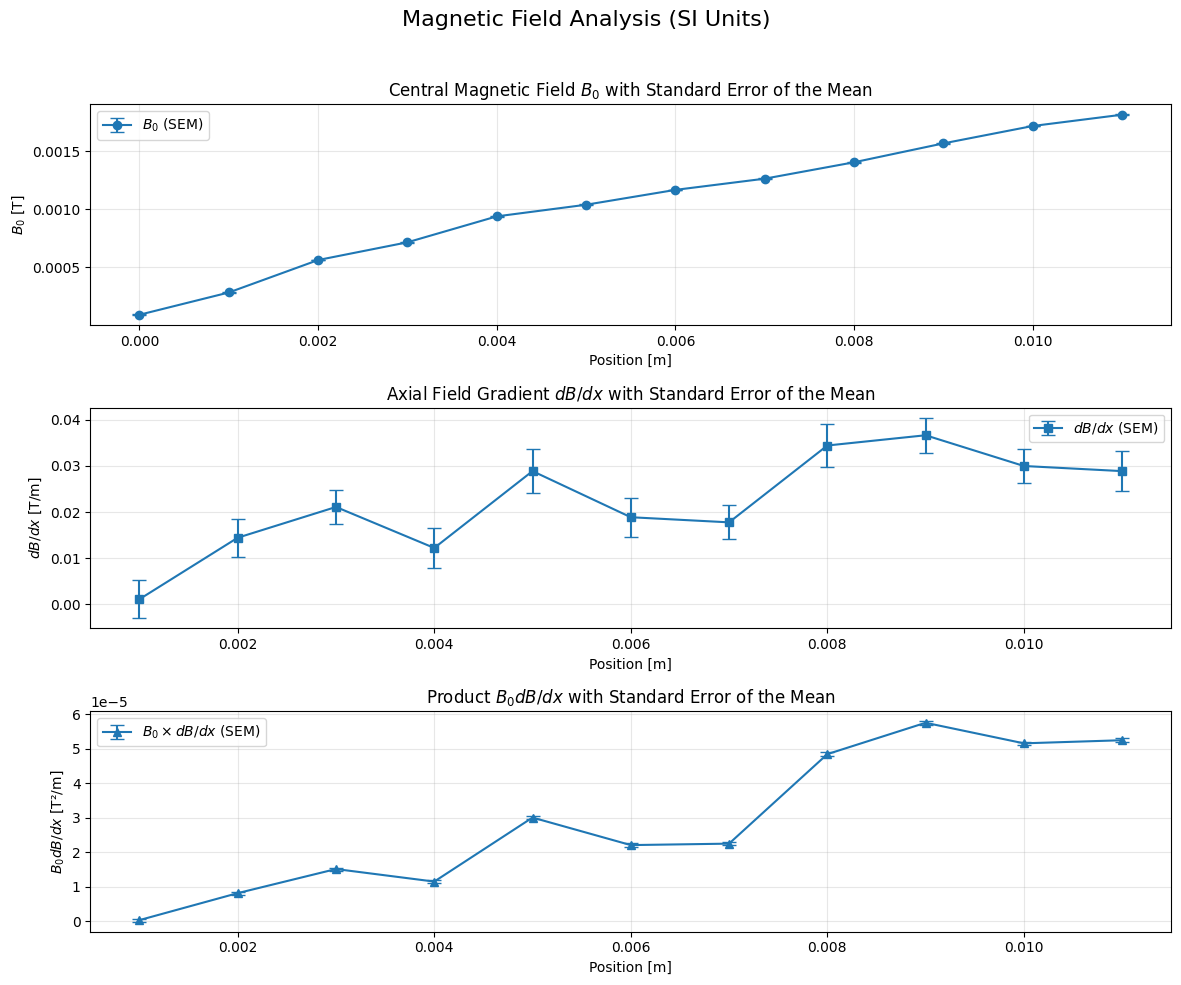

In [33]:
import matplotlib.pyplot as plt
import numpy as np  # Just in case

# Conversion factors
GAUSS_TO_TESLA = 1 / 10000  # 1 T = 10,000 Gauss
MM_TO_M = 1 / 1000         # for position if needed, but we keep x in mm for readability

# But for gradient: original dB/dx is in Gauss/mm
# To get T/m: (Gauss/mm) * (1 T / 10000 Gauss) * (1000 mm / 1 m) = value * 1000 / 10000 = value * 0.1
GRADIENT_CONVERSION = 0.1  # Gauss/mm → T/m

# For product B0 * dB/dx:
# (Gauss) * (Gauss/mm) → T * (T/m) after conversion
# So: value_in_Gauss * value_in_Gauss_per_mm * (1/10000) * (0.1) = value * 0.00001
PRODUCT_CONVERSION = GAUSS_TO_TESLA * GRADIENT_CONVERSION  # = 1e-5

plt.figure(figsize=(12, 10))
plt.suptitle("Magnetic Field Analysis (SI Units)", fontsize=16)

# Plot 1: B0 in Tesla
plt.subplot(3, 1, 1)
plt.errorbar(df_clean["Position"] * MM_TO_M, 
             df_clean["MagField Avg"] * GAUSS_TO_TESLA,
             yerr=df_clean["MagField SEM"] * GAUSS_TO_TESLA,
             fmt='o-', capsize=5, label='$B_0$ (SEM)')
plt.xlabel('Position [m]')
plt.ylabel('$B_0$ [T]')
plt.title('Central Magnetic Field $B_0$ with Standard Error of the Mean')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: dB/dx in T/m
plt.subplot(3, 1, 2)
plt.errorbar(df_clean["Position"] * MM_TO_M, 
             df_clean["dBdx"] * GRADIENT_CONVERSION,
             yerr=df_clean["dBdx SEM"] * GRADIENT_CONVERSION,
             fmt='s-', capsize=5, label='$dB/dx$ (SEM)')
plt.xlabel('Position [m]')
plt.ylabel('$dB/dx$ [T/m]')
plt.title('Axial Field Gradient $dB/dx$ with Standard Error of the Mean')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: B0 * dB/dx in T²/m
plt.subplot(3, 1, 3)
plt.errorbar(df_clean["Position"] * MM_TO_M, 
             df_clean["B0 * dBdx"] * PRODUCT_CONVERSION,
             yerr=df_clean["B0 * dBdx SEM"] * PRODUCT_CONVERSION,
             fmt='^-', capsize=5, label='$B_0 \\times dB/dx$ (SEM)')
plt.xlabel('Position [m]')
plt.ylabel('$B_0 dB/dx$ [T²/m]')
plt.title('Product $B_0 dB/dx$ with Standard Error of the Mean')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Assests/magField_behavior_SI.png", dpi=300, bbox_inches='tight')  # Fixed folder name typo
plt.show()

## **3.3 Plot and Fits**

In [9]:
scaling_factor = 1e-5   # Convert from Gauss^2/mm to T^2/m
b0dbdxunits = df_clean["B0 * dBdx"] * scaling_factor
SEMb0dbdxunits = df_clean["B0 * dBdx SEM"] * scaling_factor

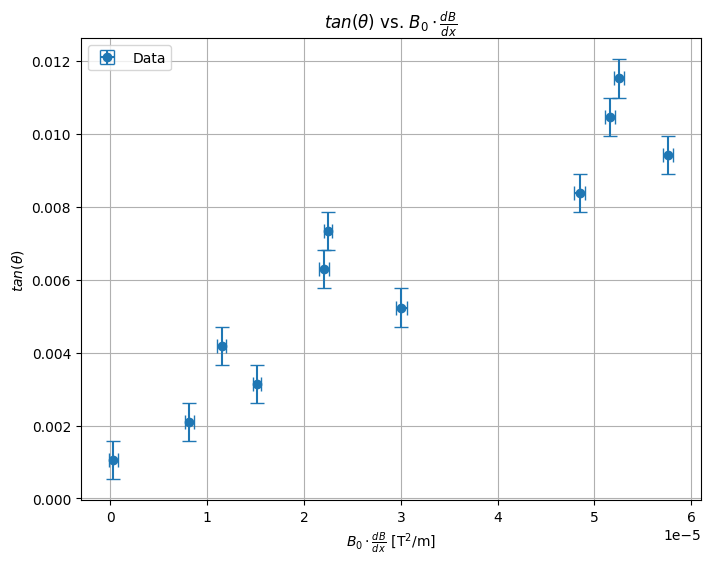

In [10]:
# Plot B0 * dBdx vs. tan(theta) with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    b0dbdxunits, df_clean["tan_theta"],
    xerr=SEMb0dbdxunits, yerr=df_clean["tan_theta Std"],
    fmt='o', capsize=5, label="Data"
)
plt.ylabel(r"$tan(\theta)$")
plt.xlabel(r"$B_0 \cdot \frac{dB}{dx}$ [T$^2$/m]")
plt.title(r"$tan(\theta)$ vs. $B_0 \cdot \frac{dB}{dx}$")
plt.legend()
plt.grid(True)
plt.show()

- **X-axis**: B0 * dB/dx (Gauss/mm) - need to switch to **Tesla/m** to analyze susceptibility.
- **Y-axis**: tan($ \theta $) (unitless).
- **Plot shows a linear trend**, but error bars seem questionable.
- The physical meaning of the graph is unclear; it mainly tests **how well the data fits the equation**:

  $$
  tan(\theta) = \frac{\chi}{\mu_0 \rho g} \cdot B \frac{dB}{dx}
  $$

then the slope gives $\chi$
    $$
   m = \frac{\chi}{\mu_0 \rho g} => \chi = m(\mu_0\rho g)
  $$

  This equation arises from **solving Newtonian motion for a pendulum at equilibrium**, where **electromagnetic force balances gravity**.

- **11 values are shown instead of 12** due to the **NaN in the first row**.


## **4. Model Fitting**


### **Fitting Functions**
- The **linear model** given the equation structure:
  
  $$ y = mx + b $$

- **Scipy's `curve_fit` was used**
- The resulting **best-fit equation**:

  $$
  y = 160.3297x + 0.0016
  $$

- `curve_fit` also provides **uncertainties** for the fit parameters:

  - **Slope**: $ 160.3186 \pm 8.2631 $
  - **Intercept**: $ 0.0160 \pm 0.003 $

- **Reduced Chi-Squared**:  
  $$ \chi^2_{\text{red}} = 6.005 $$
  - Indicates **overestimated uncertainties**.
  - The large error bars in `B0 * dB/dx` suggest a **problem with uncertainty propagation**.
  - Removing the `B0 * dB/dx` factor from its standard deviation improves **graph appearance** but worsens **Chi-squared values**.

- **Residuals appear well spread**, with **no visible pattern**, indicating a **good fit**.


The following blocks are functions needed for the fit with two sigmas

In [11]:
# Define linear function
def linear_model(x, m, b):
    return m * x + b

In [12]:
def compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, params):
    """
    Computes the effective standard deviation incorporating uncertainties in both x and y.

    Parameters:
    - x_values (array-like): Independent variable values.
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model.
    - params (tuple): Parameters of the model.

    Returns:
    - sigma_eff (array-like): Effective uncertainty combining sigma_x and sigma_y.
    """
    # Compute the derivative df/dx numerically
    delta_x = 1e-6  # Small step for numerical differentiation
    df_dx = (model_func(x_values + delta_x, *params) - model_func(x_values - delta_x, *params)) / (2 * delta_x)

    # Compute effective variance
    sigma_eff_squared = sigma_y**2 + (df_dx * sigma_x)**2
    return np.sqrt(sigma_eff_squared)

In [13]:
from scipy.optimize import curve_fit

def perform_curve_fit(x_values, y_values, sigma_x, sigma_y, model_func, initial_guess):
    """
    Performs curve fitting considering uncertainties in both x and y.

    Parameters:
    - x_values (array-like): Independent variable values (observed).
    - y_values (array-like): Dependent variable values (observed).
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model.
    - initial_guess (tuple): Initial guess for model parameters.

    Returns:
    - popt (array): Optimal values for the parameters.
    - pcov (2D array): The estimated covariance of popt.
    """
    # Perform initial fit without sigma_x
    popt, pcov = curve_fit(model_func, x_values, y_values, sigma=sigma_y, absolute_sigma=True, p0=initial_guess)

    # Compute effective sigma with the best-fit parameters
    sigma_eff = compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, popt)

    # Refit using effective sigma
    popt, pcov = curve_fit(model_func, x_values, y_values, sigma=sigma_eff, absolute_sigma=True, p0=popt)

    return popt, pcov

In [14]:
def compute_chi_squared(x_values, y_values, sigma_x, sigma_y, model_func, params):
    """
    Computes chi-squared and reduced chi-squared, incorporating both y and x uncertainties.

    Parameters:
    - x_values (array-like): Independent variable values (observed).
    - y_values (array-like): Dependent variable values (observed).
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model. (linear)
    - params (tuple): Parameters of the model. (Linear is 2)

    Returns:
    - chi_squared (float): The chi-squared value.
    - chi_squared_red (float): The reduced chi-squared value.
    """
    # Compute fitted y-values using the model function
    y_fit_values = model_func(x_values, *params)

    # Compute effective sigma
    sigma_eff = compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, params)

    # Compute chi-squared
    chi_squared = np.sum(((y_values - y_fit_values) ** 2) / sigma_eff**2)

    # Degrees of freedom
    dof = len(y_values) - len(params)

    # Reduced chi-squared
    chi_squared_red = chi_squared / dof

    print("Chi-Squared:", chi_squared)
    print("Reduced Chi-Squared:", chi_squared_red)

    return chi_squared, chi_squared_red

### curve_fit plot and $\chi_\nu^2$ test

In [15]:
# Extract observed values and uncertainties
valid_data = df_clean.dropna()
x_values = valid_data["B0 * dBdx"].values  * scaling_factor
y_values = valid_data["tan_theta"].values
sigma_x = valid_data["B0 * dBdx SEM"].values  * scaling_factor
sigma_y = valid_data["tan_theta Std"].values

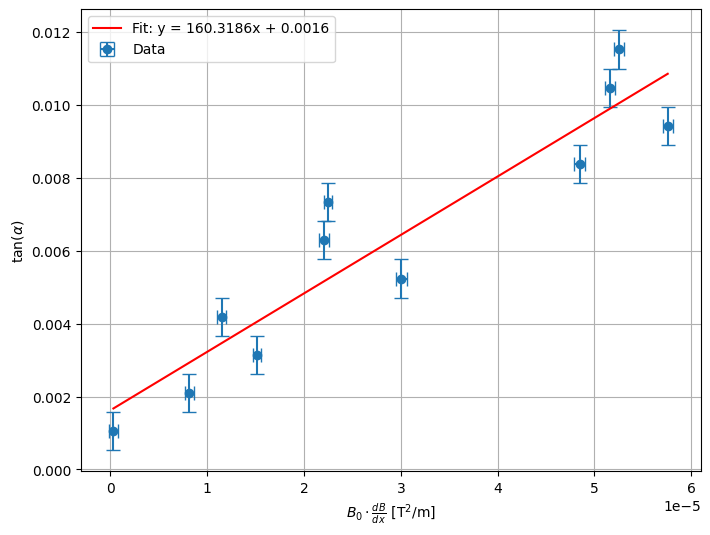

Slope: 160.3186 ± 8.2631
Intercept: 0.0016 ± 0.0003


In [16]:
# Perform curve fit
popt, pcov = perform_curve_fit(x_values, y_values, sigma_x, sigma_y, linear_model,[0,0])

# fitted parameters and uncertainties
slope_fit, intercept_fit = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))

# fit line
x_fit = np.linspace(x_values.min(), x_values.max(), 100)
y_fit = linear_model(x_fit, slope_fit, intercept_fit)

# Plot data and fit
plt.figure(figsize=(8, 6))
plt.errorbar(
    x_values, y_values,
    xerr=sigma_x, yerr=sigma_y,
    fmt='o', capsize=5, label="Data"
)

plt.plot(x_fit, y_fit, 'r-', label=f'Fit: y = {slope_fit:.4f}x + {intercept_fit:.4f}')

plt.ylabel(r"tan($\alpha$)") #changed to alpha for coherence with slides
plt.xlabel(r"$B_0 \cdot \frac{dB}{dx}$ [T$^2$/m]")
#plt.title("Curve Fit: tan($\theta$) vs. B0 * (dB/dx)")
plt.legend()
plt.grid(True)

plt.savefig("curve_fit_plot.png", dpi=300, bbox_inches='tight')

plt.show()

print(f"Slope: {slope_fit:.4f} ± {slope_err:.4f}")
print(f"Intercept: {intercept_fit:.4f} ± {intercept_err:.4f}")


In [17]:
chi_squared_linear, chi_squared_red_linear = compute_chi_squared(x_values, y_values, sigma_x, sigma_y, linear_model, popt)


Chi-Squared: 54.03449147986616
Reduced Chi-Squared: 6.003832386651796


In [18]:
print("Sigma y: \n")
print("Min uncertainty:", np.min(sigma_y))
print("Max uncertainty:", np.max(sigma_y))
print("Mean uncertainty:", np.mean(sigma_y))

print("\n")
print("Sigma x: \n")
print("Min uncertainty:", np.min(sigma_x))
print("Max uncertainty:", np.max(sigma_x))
print("Mean uncertainty:", np.mean(sigma_x))


Sigma y: 

Min uncertainty: 0.0005235613575519092
Max uncertainty: 0.0005236991466013432
Mean uncertainty: 0.0005236130266919232


Sigma x: 

Min uncertainty: 4.2700841014689935e-07
Max uncertainty: 5.740051424473285e-07
Mean uncertainty: 4.888212238536293e-07


In [19]:
popt, pcov = curve_fit(linear_model, x_values, y_values, sigma=sigma_x, absolute_sigma=True, p0=[0,0])
slope_fit, intercept_fit = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))
print(f"Slope: {slope_fit:.4f} ± {slope_err:.4f}")
print(f"Intercept: {intercept_fit:.4f} ± {intercept_err:.4f}")

Slope: 162.5306 ± 0.0076
Intercept: 0.0016 ± 0.0000


### Check the residuals

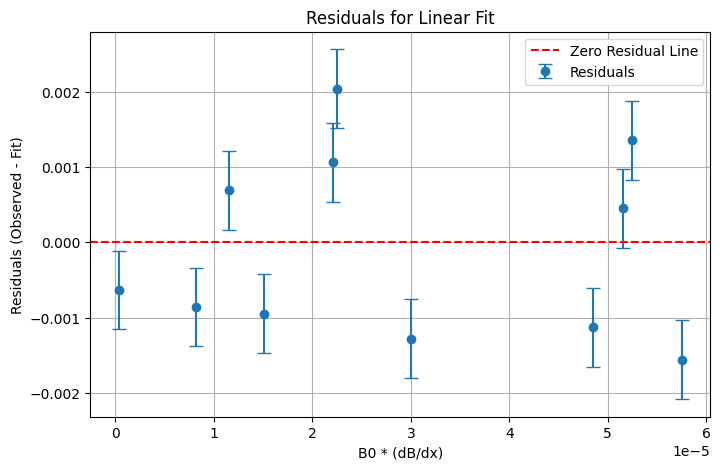

In [20]:
# Compute residuals for linear fit
y_fit_linear = linear_model(x_values, *popt)  # Fitted values from linear model
residuals_linear = y_values - y_fit_linear  # Compute residuals

# Plot residuals
plt.figure(figsize=(8, 5))
plt.errorbar(x_values, residuals_linear, yerr=sigma_y, fmt='o', capsize=5, label="Residuals")
plt.axhline(0, color='r', linestyle='--', label="Zero Residual Line")
plt.xlabel("B0 * (dB/dx)")
plt.ylabel("Residuals (Observed - Fit)")
plt.title("Residuals for Linear Fit")
plt.legend()
plt.grid(True)
plt.savefig("Assests/Residuals_Plot.png", dpi=300, bbox_inches='tight')
plt.show()

Find the suceptibility from the slope

as 

$$
\chi = m(\mu_0\rho g)
$$

In [38]:
from scipy.constants import mu_0 as mu0 #N A^-2

def calc_lead_properties(length_m, diameter_m, mass):
    """
    Calculates volume and mass of a cylindrical lead.
    
    Parameters:
        length_m (float): Length in meters
        diameter_m (float): Diameter in meters
        density_kg_m3 (float): Material density (default = 8000 for stainless steel)
        
    Returns:
        radius (float): radius in m
        volume (float): Volume in m^3
        mass (float): Mass in kg
    """
    radius = diameter_m / 2
    volume = np.pi * radius**2 * length_m
    density_kg_m3 = mass / volume
    return radius, volume, density_kg_m3


g = 9.834 #m/s2

length_mm = 6.0 
sigma_length_mm = 0.01
diameter_mm = 3.0
sigma_diameter_mm = 0.01
mass_g = 0.3648
sigma_mass_g = 0.0001

G_TO_KG = MM_TO_M

# Nominal values and their uncertainties in SI units
lead_properties = [
    length_mm * MM_TO_M,           # length (m)
    sigma_length_mm * MM_TO_M,     # uncertainty in length (m)
    diameter_mm * MM_TO_M,         # diameter (m)
    sigma_diameter_mm * MM_TO_M,   # uncertainty in diameter (m)
    mass_g * G_TO_KG,              # mass (kg)
    sigma_mass_g * G_TO_KG         # uncertainty in mass (kg)
]


m = slope_fit
sigma_m = slope_err
r, V, rho = calc_lead_properties(lead_properties[0],
                                 lead_properties[2],
                                 lead_properties[4])
print(f"Volume: {V:.3e} [m3], Density: {rho:.2f} [kg/m3]")

chi = m * mu0 * rho * g # m / T^2 * N A^2 * kg/m^3 * m/s2, (unitless)
mchi = m * mu0 * g # m / T^2 * N A^2  * m/s2, m3/kg

print(f" Mass magnetic susceptibility: {mchi:.2e} [m3/kg], Magnetic susceptibility: {chi:.2f}" )

Volume: 4.241e-08 [m3], Density: 8601.44 [kg/m3]
 Mass magnetic susceptibility: 2.01e-03 [m3/kg], Magnetic susceptibility: 17.28


In [42]:
def rel_error(var, sigma_var,):
    """Relative error for a variable (σ_var / var)"""
    return sigma_var / var

def propagate_product_rel(*rel_errors):
    """Add relative errors in quadrature for a product/quotient"""
    return np.sqrt(sum(re**2 for re in rel_errors))

# Calculations with error propagation

# Volume in mm³ (easier numbers)
rel_err_rad = rel_error(r, lead_properties[3]) 
rel_err_len = rel_error(lead_properties[0], lead_properties[1]) 
rel_err_vol  = propagate_product_rel(rel_err_rad, rel_err_len)
sigma_V = V * rel_err_vol

# Density
rel_err_mass = rel_error(lead_properties[4],lead_properties[5])
rel_err_dens = propagate_product_rel(rel_err_mass, rel_err_vol)  # mass / volume
sigma_rho = rho * rel_err_dens

# Volume magnetic susceptibility χ = mχ × ρ
rel_err_slope = rel_error(sigma_m,m)
rel_err_msus = propagate_product_rel(rel_err_slope)
sigma_msus = mchi * rel_err_msus

rel_err_msus = propagate_product_rel(rel_err_slope,rel_err_dens)
sigma_sus = chi * rel_err_sus

# Print results
print(f"Volume: ({V:.3e} ± {sigma_V:.3e}) m³")
print(f"Density: {rho:.0f} ± {sigma_rho:.0f} kg/m³")
print(f"Mass mag. susc. mχ: ({mchi:.2e} ± {sigma_msus:.2e}) m³/kg")
print(f"Magnetic susceptibility χ: {chi:.2f} ± {sigma_sus:.2f}")

Volume: (4.241e-08 ± 2.914e-10) m³
Density: 8601 ± 59 kg/m³
Mass mag. susc. mχ: (2.01e-03 ± 4.29e+01) m³/kg
Magnetic susceptibility χ: 17.28 ± 0.12


## **5. Summary and Conclusion**
- The experiment aimed to test whether **tan($\theta$) vs. B0 * dB/dx** follows a **linear model**.
- **Data cleaning ensured consistency**, dropping unneeded metadata and recomputing all statistics.
- **Uncertainty propagation**, but the trend suggested that **uncertainties grow disproportionately with B**.
    - **Fixed with Standard Error of the Mean**, now the values are more credible.
- **Linear fitting seems okay**, yields **a reasonable equation but units are troublesome**.
- **Chi-squared statistics suggest errors are underestimated**.
 
- With measuremntes on size and weight of the metalic rod, we found Magnetic susceptibility: 17.28
  - whichs quite high I'd suspect, especially given the density of 8601.44 kg/m3
  - Removing the density of the rod, the Mass magnetic susceptibility: 2.01e-03

In [22]:
df

,N,Position,Current,Magnetic Field Intensity at PositionNm0.5mm,Magnetic Field Intensity at PositionNm0.5mm.1,Magnetic Field Intensity at PositionNm0.5mm.2,Magnetic Field Intensity at PositionNm0.5mm.3,Magnetic Field Intensity at PositionNm0.5mm.4,Magnetic Field Intensity at PositionNm0.5mm.5,Magnetic Field Intensity at PositionNm0.5mm.6,...,Magnetic Field Intensity at PositionNp0.5mm.6,Magnetic Field Intensity at PositionNp0.5mm.7,Magnetic Field Intensity at PositionNp0.5mm.8,MF-0.5mm Avg,MagField Avg,MF+0.5mm Avg,Gradient,Angular position,L is in mm,955
0,NaN,x [mm] +- 0.05 mm,I [A] +- 0.001A,B [Gauss] ...,m 2,m 3,m 4,m 5,m 6,m 7,...,m 7,m 8,m 9,B [Gauss],B0 [Gauss],B [Gauss],dB/dx,theta,Tan(theta),B0*(dB/dx)
1,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0.8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1,0.554,2.9,2.8,2.9,2.9,2.8,2.7,2.9,...,2.9,2.8,2.7,2.855555556,2.811111111,2.844444444,0.111111111,0.001047121,0.001047121,0.312345679
3,3.0,2,1.221,5.6,5.5,5.7,5.6,5.4,5.5,5.6,...,5.7,5.6,5.8,5.555555556,5.655555556,5.7,1.444444444,0.002094242,0.002094245,8.169135802
4,4.0,3,1.636,7,7.1,7,6.9,7.1,7.1,7,...,7.1,7.2,7.3,7.033333333,7.222222222,7.244444444,2.111111111,0.003141366,0.003141377,15.24691358
5,5.0,4,2.217,9.3,9.2,9.4,9.3,9.2,9.4,9.3,...,9.4,9.6,9.4,9.322222222,9.444444444,9.444444444,1.222222222,0.004188494,0.004188518,11.54320988
6,6.0,5,2.471,10.3,10.4,10.4,10.3,10.4,10.2,10.1,...,10.7,10.5,10.6,10.26666667,10.4,10.55555556,2.888888889,0.005235626,0.005235674,30.04444444
7,7.0,6,2.752,11.7,11.6,11.7,11.6,11.6,11.7,11.6,...,12,11.7,11.8,11.61111111,11.65555556,11.8,1.888888889,0.006282764,0.006282847,22.01604938
8,8.0,7,2.966,12.6,12.7,12.6,12.5,12.5,12.6,12.4,...,12.8,12.7,12.8,12.57777778,12.63333333,12.75555556,1.777777778,0.007329909,0.00733004,22.45925926
9,9.0,8,3.196,14,13.9,13.9,14.1,14,13.9,13.8,...,14.2,14.4,14.1,13.92222222,14.02222222,14.26666667,3.444444444,0.008377061,0.008377257,48.29876543
